
# CAICLE — LightGBM Fine-Tuning
**Goal:** Systematically fine-tune the LightGBM model and measure impact **one change at a time**.

**Primary metric:** Balanced Accuracy (Per-Class Accuracy)  
**Secondary metrics:** Recall (class 1 = Top 30), F1 (class 1)

**Experiment track:**
1. **A. Baseline** (all years 2017–2021, all features)  
2. **B. Ablation: only `sumres_1`, drop `sumres_2`, `sumres_3`** (more recent history emphasis)
3. **C. Recency only:** train/evaluate **only on 2021** data


In [4]:

import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt

try:
    import seaborn as sns
except ImportError:
    sns = None

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, recall_score, f1_score, classification_report, confusion_matrix
from lightgbm import LGBMClassifier

RANDOM_STATE = 42
DATA_DIR = Path("data")


## Load & combine all years (2017-2021)

In [5]:

def load_all_years(data_dir=DATA_DIR):
    files = sorted((data_dir).glob("cleaned_data_20*.csv"))
    if not files:
        raise FileNotFoundError(f"No files found in {data_dir} matching cleaned_data_20*.csv")
    dfs = [pd.read_csv(f) for f in files]
    df = pd.concat(dfs, ignore_index=True)
    return df, files

def load_single_year(year=2021, data_dir=DATA_DIR):
    p = data_dir / f"cleaned_data_{year}.csv"
    if not p.exists():
        raise FileNotFoundError(f"{p} not found")
    return pd.read_csv(p), p


## Evaluation helper (Balanced Accuracy + Recall for class 1)

In [6]:

def evaluate_model(model_name, y_true, y_pred):
    bal = balanced_accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred, pos_label=1)
    f1  = f1_score(y_true, y_pred, pos_label=1)

    print(f"\n==================== {model_name} ====================")
    print(f"Balanced Accuracy: {bal:.4f}")
    print(f"Recall (class 1): {rec:.4f}")
    print(f"F1 (class 1):     {f1:.4f}\n")
    print(classification_report(y_true, y_pred, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    if sns is not None:
        plt.figure(figsize=(4,3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Pred 0','Pred 1'], yticklabels=['True 0','True 1'])
        plt.title(f"{model_name} — Confusion Matrix (Test)")
        plt.tight_layout(); plt.show()
    return bal, rec, f1


## Data splitting and ... (stratified 70/15/15)

In [7]:

def run_lgbm_train_eval(df, feature_drop=None, label_col='target', experiment_name="LGBM"):
    X = df.drop(columns=[label_col])
    if feature_drop:
        to_drop = [c for c in feature_drop if c in X.columns]
        X = X.drop(columns=to_drop)
    y = df[label_col]
    feature_names = X.columns.tolist()

    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=RANDOM_STATE
    )

    cnt = y_train.value_counts().sort_index()
    neg, pos = int(cnt[0]), int(cnt[1])
    scale_pos_weight = neg / pos

    model = LGBMClassifier(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='binary_logloss'
    )

    y_pred = model.predict(X_test)
    bal, rec, f1 = evaluate_model(experiment_name, y_test, y_pred)

    importances = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False)
    print("Top 15 features:\n", importances.head(15))
    importances.head(15).plot(kind='bar', figsize=(8,4), title=f'{experiment_name} — Top Feature Importances')
    plt.tight_layout(); plt.show()

    return {'exp': experiment_name, 'bal_acc': bal, 'rec1': rec, 'f1_1': f1}, model


## A. LGBM — Baseline (All years, all features)

Loaded files: ['cleaned_data_2017.csv', 'cleaned_data_2018.csv', 'cleaned_data_2019.csv', 'cleaned_data_2020.csv', 'cleaned_data_2021.csv']
Shape: (120261, 18)
Columns: ['target', 'GC', 'Age', 'Length', 'height', 'weight', 'One day races', 'GC_specialty', 'Time trial', 'Sprint', 'Climber', 'PCS Ranking', 'UCI World Ranking', 'Specials | All Time Ranking', 'sumres_1', 'sumres_2', 'sumres_3', 'Stage_Type_RR']
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 17265, number of negative: 66917
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3235
[LightGBM] [Info] Number of data points in the train set: 84182, number of used features: 17
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.205091 -> initscore

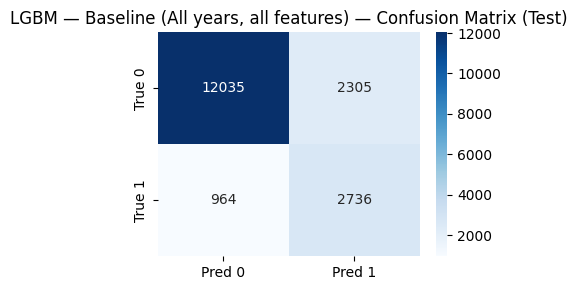

Top 15 features:
 Length               3397
GC                   2661
sumres_1             1321
sumres_2             1146
sumres_3             1078
Age                   916
weight                818
Time trial            763
height                750
UCI World Ranking     744
Climber               724
Sprint                722
GC_specialty          706
PCS Ranking           671
One day races         667
dtype: int32


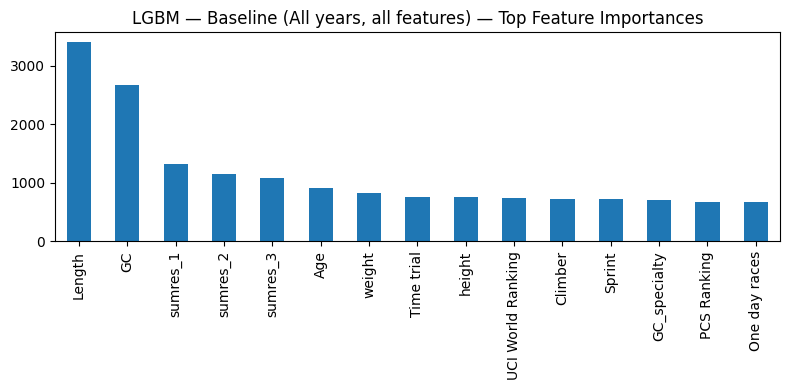

,exp,bal_acc,rec1,f1_1
0,"LGBM — Baseline (All years, all features)",0.78936,0.739459,0.626015


In [8]:

results = []

df_all, files = load_all_years()
print("Loaded files:", [f.name for f in files])
print("Shape:", df_all.shape)
print("Columns:", list(df_all.columns))

resA, modelA = run_lgbm_train_eval(df_all, feature_drop=None, experiment_name="LGBM — Baseline (All years, all features)")
results.append(resA)
pd.DataFrame(results)


## B. LGBM — Only sumres_1 (drop 2 & 3)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 17265, number of negative: 66917
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2727
[LightGBM] [Info] Number of data points in the train set: 84182, number of used features: 15
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.205091 -> initscore=-1.354772
[LightGBM] [Info] Start training from score -1.354772

==================== LGBM — Only sumres_1 (drop 2 & 3) ====================
Balanced Accuracy: 0.7916
Recall (class 1): 0.7476
F1 (class 1):     0.6271

              precision    recall  f1-score   support

           0     0.9277    0.8357    0.8793     14340
           1     0.5400    0.7476    0.6271      3700

    accuracy                

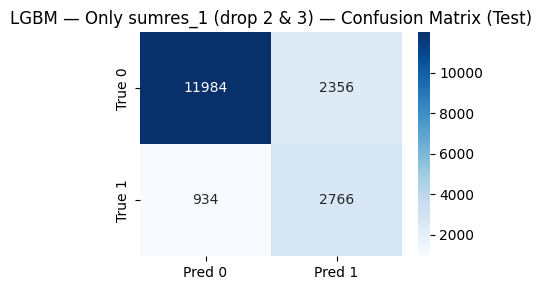

Top 15 features:
 Length                         3394
GC                             3222
sumres_1                       1641
Age                            1138
weight                          968
height                          936
Time trial                      915
Sprint                          893
UCI World Ranking               800
GC_specialty                    796
Climber                         793
PCS Ranking                     787
One day races                   742
Specials | All Time Ranking     607
Stage_Type_RR                   368
dtype: int32


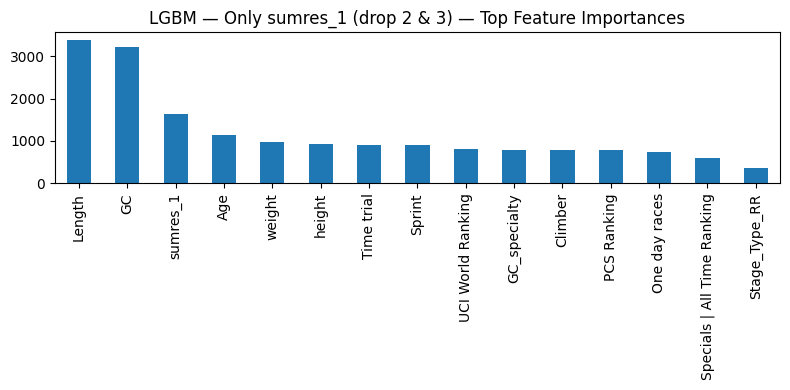

,exp,bal_acc,rec1,f1_1
0,"LGBM — Baseline (All years, all features)",0.789360,0.739459,0.626015
1,LGBM — Only sumres_1 (drop 2 & 3),0.791636,0.747568,0.627069


In [9]:

drop_feats = ['sumres_2','sumres_3']
resB, modelB = run_lgbm_train_eval(df_all, feature_drop=drop_feats, experiment_name="LGBM — Only sumres_1 (drop 2 & 3)")
results.append(resB)
pd.DataFrame(results)


## C. LGBM — Only 2021 data

Using: cleaned_data_2021.csv shape: (28241, 18)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4073, number of negative: 15695
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2866
[LightGBM] [Info] Number of data points in the train set: 19768, number of used features: 17
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.206040 -> initscore=-1.348962
[LightGBM] [Info] Start training from score -1.348962

==================== LGBM — Only 2021 data ====================
Balanced Accuracy: 0.8227
Recall (class 1): 0.7709
F1 (class 1):     0.6839

              precision    recall  f1-score   support

           0     0.9363    0.8746    0

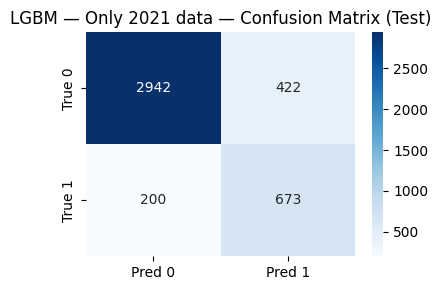

Top 15 features:
 Length               4029
GC                   3434
sumres_1             1096
sumres_2              958
Age                   926
sumres_3              798
height                795
Time trial            792
weight                752
PCS Ranking           672
Sprint                652
Climber               639
GC_specialty          605
One day races         578
UCI World Ranking     564
dtype: int32


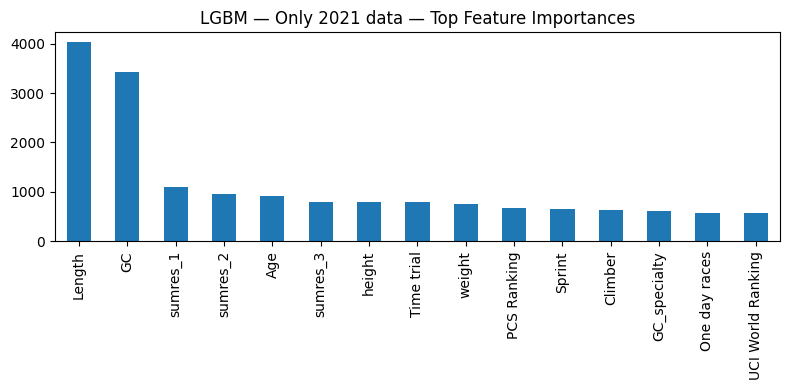

,exp,bal_acc,rec1,f1_1
0,"LGBM — Baseline (All years, all features)",0.789360,0.739459,0.626015
1,LGBM — Only sumres_1 (drop 2 & 3),0.791636,0.747568,0.627069
2,LGBM — Only 2021 data,0.822730,0.770905,0.683943


In [10]:

df_2021, p2021 = load_single_year(2021)
print("Using:", p2021.name, "shape:", df_2021.shape)

resC, modelC = run_lgbm_train_eval(df_2021, feature_drop=None, experiment_name="LGBM — Only 2021 data")
results.append(resC)
pd.DataFrame(results)


## Summary

In [ ]:

summary = pd.DataFrame(results).sort_values(by='bal_acc', ascending=False).reset_index(drop=True)
print("🔹 Ranked by Balanced Accuracy")
display(summary.style.format({'bal_acc':'{:.4f}', 'rec1':'{:.4f}', 'f1_1':'{:.4f}'})
        .background_gradient(subset=['bal_acc'], cmap='Blues')
        .background_gradient(subset=['rec1'], cmap='Greens')
        .background_gradient(subset=['f1_1'], cmap='Oranges'))
summary


🔹 Ranked by Balanced Accuracy


,exp,bal_acc,rec1,f1_1
0,LGBM — Only 2021 data,0.8227,0.7709,0.6839
1,LGBM — Only sumres_1 (drop 2 & 3),0.7916,0.7476,0.6271
2,"LGBM — Baseline (All years, all features)",0.7894,0.7395,0.6260


,exp,bal_acc,rec1,f1_1
0,LGBM — Only 2021 data,0.822730,0.770905,0.683943
1,LGBM — Only sumres_1 (drop 2 & 3),0.791636,0.747568,0.627069
2,"LGBM — Baseline (All years, all features)",0.789360,0.739459,0.626015
